In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV,GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score,ConfusionMatrixDisplay, accuracy_score

In [29]:
import warnings
warnings.filterwarnings('ignore')

# Data Analysis 

In [30]:
siren_data =pd.read_csv("siren_data_train.csv")

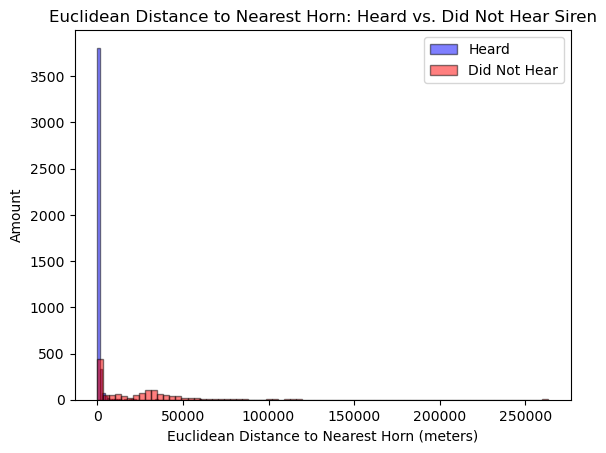

In [31]:
siren_data =pd.read_csv("siren_data_train.csv")
##(i) Does the distance to the nearest horn affect whether a person hears the siren or not?

#Calculate the Euclidean Distance between each person's location (xcoor, ycoor) and the nearest horn´s location (near_x, near_y).
siren_data['dist'] = np.sqrt((siren_data['near_x'] - siren_data['xcoor'])**2 + (siren_data['near_y'] - siren_data['ycoor'])**2)

#Plot histograms to compare distance distributions for "Heard" vs. "Did Not Hear"
plt.hist(siren_data[siren_data['heard'] == 1]['dist'], 
         bins=75,
         color='blue', 
         label='Heard', 
         alpha=0.5,
         edgecolor='black')  
plt.hist(siren_data[siren_data['heard'] == 0]['dist'], 
         bins=75,
         color='red', 
         label='Did Not Hear', 
         alpha=0.5,
         edgecolor='black')

#Adding title, lables and legend.
plt.title('Euclidean Distance to Nearest Horn: Heard vs. Did Not Hear Siren')
plt.xlabel('Euclidean Distance to Nearest Horn (meters)')
plt.ylabel('Amount')
plt.legend()
plt.show()

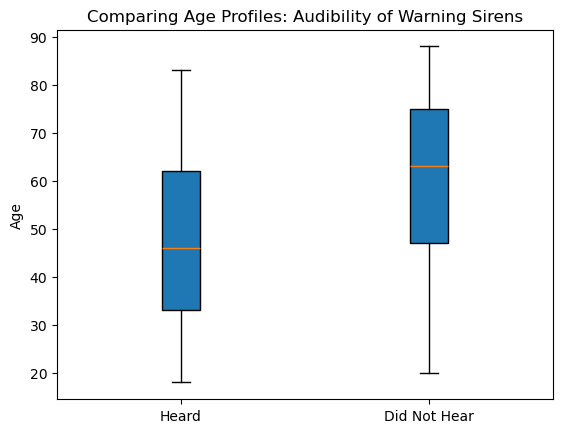

In [32]:
##(ii) Are the people who hear the siren younger than the people who do not hear it?

#Generate summary statistics for age based on siren audibility
age_stats = siren_data.groupby('heard')['age'].describe()

#Plot age distributions as boxplots for "Heard" and "Did Not Hear" groups
data_to_plot = [siren_data[siren_data['heard'] == 1]['age'], siren_data[siren_data['heard'] == 0]['age']]
plt.boxplot(data_to_plot, labels=['Heard', 'Did Not Hear'], patch_artist=True)
plt.title('Comparing Age Profiles: Audibility of Warning Sirens')
plt.ylabel('Age')
plt.xticks([1, 2], ['Heard', 'Did Not Hear'])
plt.show()


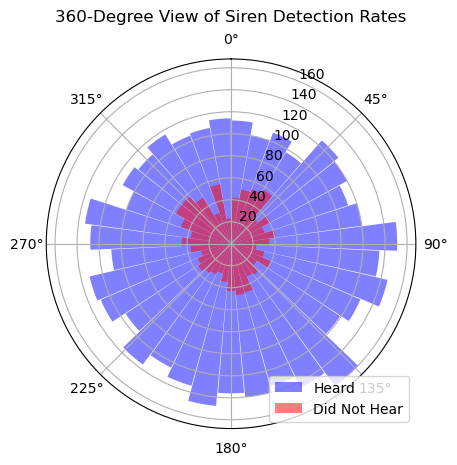

In [33]:
##(iii) Does the direction towards the nearest horn affect whether a person hears the siren or not?

#Convert directional angles from degrees to radians for polar plotting
siren_data['near_angle_rad'] = np.deg2rad(siren_data['near_angle'])

#Compute angle histograms for both "Heard" and "Did Not Hear" groups
hist_heard, bins = np.histogram(siren_data[siren_data['heard'] == 1]['near_angle_rad'], bins=np.linspace(-np.pi, np.pi, 36))
hist_not_heard, _ = np.histogram(siren_data[siren_data['heard'] == 0]['near_angle_rad'], bins=np.linspace(-np.pi, np.pi, 36))

#Set up the polar plot for directional data visualization
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

#Plot angle histograms for both groups on the polar plot
ax.bar(bins[:-1], hist_heard, width=(2*np.pi) / 36, color='blue', label='Heard', alpha=0.5)
ax.bar(bins[:-1], hist_not_heard, width=(2*np.pi) / 36, color='red', label='Did Not Hear', alpha=0.5)

#Adding title, legend, and grid
ax.set_title('360-Degree View of Siren Detection Rates', va='bottom')
plt.legend(loc='lower right')
plt.show()



In [34]:
classes = [10, 20, 30, 40, 50, 60, 70, 80, 90]
ages = (1, 2, 3, 4, 5, 6, 7, 8)

#converting ages into 8 age groups 
siren_data['age_groups'] = pd.cut(siren_data['age'], bins=classes, labels=ages)

In [35]:
#drop all unnecessary columns
siren_data=siren_data.drop(["near_fid", "near_y","near_x","ycoor","xcoor", "age", "near_angle","near_angle_rad"],axis=1)

In [36]:
#splitting data into training and test dataset for model training and final prediction
X_train, X_test,y_train, y_test = train_test_split(siren_data.drop(["heard"], axis=1), siren_data.heard, train_size=90, random_state=42)

In [38]:
# we did our own test dataset 
# we made the final model selection based on the models' performance on this specifically prepared dataset
X_train['heard']=y_train
X_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
# X_train.to_csv("train.csv", index_label = False, index=False)

X_test['heard']=y_test
X_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
# X_test.to_csv("test.csv", index_label = False, index=False)

# Data loading

In [57]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

train/validation/test split 70%/20%/10%

In [71]:
X_train, X_val,y_train, y_val = train_test_split(train.drop(["heard"], axis=1), train.heard, train_size=int(len(train)*0.7/0.9), random_state=32)
X_test, y_test =test.drop(["heard"], axis=1), test.heard

# Logistic Regression

In [72]:
# Using grid search to tune the hyperparameters, which will be used next
hyperparam = {'C': [0.1, 1, 10, 100], 
              'penalty': ['l1', 'l2'], 
              'solver': ['liblinear', 'saga'], 
              'max_iter': [10,20, 30, 40, 50, 60, 70, 80, 90, 100]}

model = skl_lm.LogisticRegression()
grid_search = GridSearchCV(model, param_grid=hyperparam, cv=5, scoring='accuracy')
result = grid_search.fit(X_train, y_train)
print(result.best_params_)

{'C': 1, 'max_iter': 90, 'penalty': 'l1', 'solver': 'liblinear'}


In [73]:
model_lr = skl_lm.LogisticRegression(**result.best_params_)
model_lr.fit(X_train, y_train)
y_pred=model_lr.predict(X_val)


print("---- Validation data classifications: Logistic Regression ----")
print("Accuracy: " ,np.mean(y_val == y_pred))
print("F1-score: " ,f1_score(y_val, y_pred))
print("Precision: " ,precision_score(y_val,y_pred))
print("Recall: " ,recall_score(y_val, y_pred))
print("Confution matrix: \n" ,confusion_matrix(y_val, y_pred))

---- Validation data classifications: Logistic Regression ----
Accuracy:  0.9238845144356955
F1-score:  0.9503707929264119
Precision:  0.9328107502799552
Recall:  0.9686046511627907
Confution matrix: 
 [[223  60]
 [ 27 833]]


# K-nearest neighbor

K-value:  10


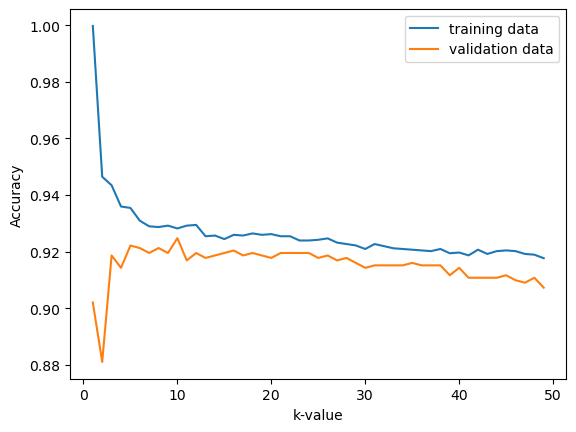

In [74]:
acc_val=[]
acc_train=[]
# training scaler based on training data
scaler=StandardScaler().fit(X_train)
for i in range(1,50):
    
    model = skl_nb.KNeighborsClassifier(n_neighbors=i)
    # data scaling
    model.fit(scaler.transform(X_train), y_train)
    y_pred=model.predict(scaler.transform(X_val))
    acc_val.append(np.mean(y_val == y_pred))
    
    y_pred=model.predict(scaler.transform(X_train))
    acc_train.append(np.mean(y_train == y_pred))
    
plt.plot(range(1,50), acc_train, label="training data")
plt.plot(range(1,50), acc_val, label="validation data")
plt.xlabel("k-value")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("k_value.png")

k=np.argmax(acc_val)+1
print("K-value: ", k)


In [75]:
model_knn = skl_nb.KNeighborsClassifier(n_neighbors=k)
model_knn.fit(scaler.transform(X_train), y_train)
y_pred=model_knn.predict(scaler.transform(X_val))


print("---- Validation data classifications: k-NN ----")
print("Accuracy: " ,np.mean(y_val == y_pred))
print("F1-score: " ,f1_score(y_val, y_pred))
print("Precision: " ,precision_score(y_val,y_pred))
print("Recall: " ,recall_score(y_val, y_pred))
print("Confution matrix: \n" ,confusion_matrix(y_val, y_pred))

---- Validation data classifications: k-NN ----
Accuracy:  0.9247594050743657
F1-score:  0.9504608294930875
Precision:  0.9417808219178082
Recall:  0.9593023255813954
Confution matrix: 
 [[232  51]
 [ 35 825]]


# Tree-based methods: RandomForest Classifier

In [76]:
# Create Random Forest object and fit to training data
clf = RandomForestClassifier(criterion="gini", n_estimators=100, max_features="sqrt", random_state=42, n_jobs=-1)

# Hyperparameter tuning with random search. GridSearch too expensive
n_estimators = np.linspace(10, 200).astype(int)
max_depth = [None] + list(np.linspace(1, 20).astype(int))
max_features = ["auto", "sqrt", None] + list(np.arange(0.5, 1, 0.1))
max_leaf_nodes = [None] + list(np.linspace(10, 50, 500).astype(int))
min_samples_split = [1, 2, 3, 5, 10, 15]
bootstrap = [True, False]
random_state = [42]

param_grid = {"n_estimators": n_estimators,
              "max_depth": max_depth,
              "max_features": max_features,
              "max_leaf_nodes": max_leaf_nodes,
              "min_samples_split": min_samples_split,
              "bootstrap": bootstrap,
              "random_state": random_state
              }

# Perform random search and fit
rand_search = RandomizedSearchCV(clf, param_grid, n_jobs=-1, scoring="accuracy", cv=5, n_iter=10, verbose=1, random_state=42)
rand_search.fit(X_train, y_train)
best_params_rf = rand_search.best_params_
print("Best parameters: \n", best_params_rf)
# Best model
model_rf = RandomForestClassifier(**best_params_rf)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_val)

print("---- Validation data classifications: Random Forest ----")
print("Accuracy: " ,np.mean(y_val == y_pred))
print("F1-score: " ,f1_score(y_val, y_pred))
print("Precision: " ,precision_score(y_val,y_pred))
print("Recall: " ,recall_score(y_val, y_pred))
print("Confution matrix: \n" ,confusion_matrix(y_val, y_pred))

# Final tree shapes
n_tree_nodes = []
avg_depths_trees = []



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: 
 {'random_state': 42, 'n_estimators': 91, 'min_samples_split': 3, 'max_leaf_nodes': 14, 'max_features': 0.7999999999999999, 'max_depth': 11, 'bootstrap': True}
---- Validation data classifications: Random Forest ----
Accuracy:  0.9282589676290464
F1-score:  0.952819332566168
Precision:  0.9430523917995444
Recall:  0.9627906976744186
Confution matrix: 
 [[233  50]
 [ 32 828]]


# Boosting:  AdaBoost Classifier

In [77]:
#Define ranges for n_estimators / learning_rate
n_estimators_range = range(50, 501, 5)
learning_rate_range = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25]

#Initialize variables to track the best performance
best_accuracy = 0
best_params = {}
best_y_pred = None

#Loop over the ranges of hyperparameters
for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        ada_boost_clf = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )
        
        #Training model
        ada_boost_clf.fit(X_train, y_train)
        
        #Make predictions - evaluate
        y_pred = ada_boost_clf.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        #Update best model if current model is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}
            best_y_pred = y_pred  #Store predictions from the best model



In [78]:
best_params

{'n_estimators': 50, 'learning_rate': 0.25}

In [79]:
model_boosting = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            **best_params
            )
        
        #Training model
model_boosting.fit(X_train, y_train)
y_pred = model_boosting.predict(X_val)


print("---- Validation data classifications: AdaBoost ----")
print("Accuracy: " ,np.mean(y_val == y_pred))
print("F1-score: " ,f1_score(y_val, y_pred))
print("Precision: " ,precision_score(y_val,y_pred))
print("Recall: " ,recall_score(y_val, y_pred))
print("Confution matrix: \n" ,confusion_matrix(y_val, y_pred))

---- Validation data classifications: AdaBoost ----
Accuracy:  0.9343832020997376
F1-score:  0.9570200573065902
Precision:  0.943502824858757
Recall:  0.9709302325581395
Confution matrix: 
 [[233  50]
 [ 25 835]]


# Evaluation based on our test data

In [80]:
model_lr.fit(X_train, y_train)
y_pred=model_lr.predict(X_test)
print("---- Test data classifications: Logistic Regression ----")
print("Accuracy: " ,np.mean(y_test == y_pred))
print("F1-score: " ,f1_score(y_test, y_pred))
print("Precision: " ,precision_score(y_test,y_pred))
print("Recall: " ,recall_score(y_test, y_pred))
print("Confution matrix: \n" ,confusion_matrix(y_test, y_pred))
    
model_knn.fit(X_train, y_train)
y_pred=model_knn.predict(X_test)
print("\n---- Test data classifications: kNN ----")
print("Accuracy: " ,np.mean(y_test == y_pred))
print("F1-score: " ,f1_score(y_test, y_pred))
print("Precision: " ,precision_score(y_test,y_pred))
print("Recall: " ,recall_score(y_test, y_pred))
print("Confution matrix: \n" ,confusion_matrix(y_test, y_pred))
    
model_rf.fit(X_train, y_train)
y_pred=model_rf.predict(X_test)
print("\n---- Test data classifications: Random Forest ----")
print("Accuracy: " ,np.mean(y_test == y_pred))
print("F1-score: " ,f1_score(y_test, y_pred))
print("Precision: " ,precision_score(y_test,y_pred))
print("Recall: " ,recall_score(y_test, y_pred))
print("Confution matrix: \n" ,confusion_matrix(y_test, y_pred))
    
model_boosting.fit(X_train, y_train)
y_pred=model_boosting.predict(X_test)
print("\n---- Test data classifications: AdaBoost ----")
print("Accuracy: " ,np.mean(y_test == y_pred))
print("F1-score: " ,f1_score(y_test, y_pred))
print("Precision: " ,precision_score(y_test,y_pred))
print("Recall: " ,recall_score(y_test, y_pred))
print("Confution matrix: \n" ,confusion_matrix(y_test, y_pred))
    
  

---- Test data classifications: Logistic Regression ----
Accuracy:  0.9211908931698775
F1-score:  0.9484536082474226
Precision:  0.9261744966442953
Recall:  0.971830985915493
Confution matrix: 
 [[112  33]
 [ 12 414]]

---- Test data classifications: kNN ----
Accuracy:  0.9001751313485113
F1-score:  0.9357384441939121
Precision:  0.9002169197396963
Recall:  0.9741784037558685
Confution matrix: 
 [[ 99  46]
 [ 11 415]]

---- Test data classifications: Random Forest ----
Accuracy:  0.9246935201401051
F1-score:  0.9504036908881198
Precision:  0.9342403628117913
Recall:  0.9671361502347418
Confution matrix: 
 [[116  29]
 [ 14 412]]

---- Test data classifications: AdaBoost ----
Accuracy:  0.9299474605954466
F1-score:  0.9543378995433789
Precision:  0.9288888888888889
Recall:  0.9812206572769953
Confution matrix: 
 [[113  32]
 [  8 418]]


# Final prediction

In [88]:
test = pd.read_csv("test_without_labels.csv")

In [89]:
#Calculate the Euclidean Distance between each person's location (xcoor, ycoor) and the nearest horn´s location (near_x, near_y).
test['dist'] = np.sqrt((test['near_x'] - test['xcoor'])**2 + (test['near_y'] - test['ycoor'])**2)

In [90]:
#converting ages into 8 age groups 
classes = [10, 20, 30, 40, 50, 60, 70, 80, 90]
ages = (1, 2, 3, 4, 5, 6, 7, 8)
test['age_groups'] = pd.cut(test['age'], bins=classes, labels=ages)

In [91]:
#drop all unnecessary columns
test=test.drop(["near_fid", "near_y","near_x","ycoor","xcoor", "age", "near_angle"],axis=1)

In [92]:
# prediction on test data using trained Adaboost classifier
y_pred=model_boosting.predict(test)


In [93]:
len(y_pred)

635

In [94]:
import csv

# Write predictions to predictions.csv
with open('predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(y_pred)
